# Part 7: Token-based — BPE tokenizer (128 tokens)

This notebook uses:
- **`tokenizer`** — BPE tokenizer (128 tokens) learned from the corpus
- **`data_loading`** — dataset download, normalization, category vocabulary, and **token-level** dataset building
- **`model`** — `CategoryConditionedNameModel` for category-conditioned **next-token** prediction

Words are tokenized with BPE before building (X, Y, C); the model predicts the next token instead of the next character.

In [1]:
import sys
from pathlib import Path

# Ensure project root is on path (run from repo root or from part6)
root = Path.cwd() if Path.cwd().name != "part7" else Path.cwd().parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from data_loading import (
    load_words_and_categories,
    build_category_vocabulary,
    get_train_val_test_splits_tokens,
    validate_dataset,
)
from tokenizer import BPETokenizer, tokenizer_vocab
from model import CategoryConditionedNameModel, ModelConfig

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

Using device: cuda
GPU: NVIDIA GeForce RTX 5060


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")
print(f"Dataset path: {dataset_path}")

d:\dev\namegens\namegens\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [3]:
# Load words and categories (optional: add extra CSV)
extra_csv = Path("data/forgotten_realms_inhabitants_by_race.csv")
if not extra_csv.is_file():
    extra_csv = Path("../data/forgotten_realms_inhabitants_by_race.csv")
extra_csv = str(extra_csv) if extra_csv.is_file() else None

words, categories = load_words_and_categories(
    dirs_configs = [{"dir_path": dataset_path}],
files_configs = [{"file_path": extra_csv, "name_column": "name", "category_column": "source_category"}] if extra_csv else []
    #extra_category_column="source_category",
)
print(f"Loaded {len(words)} words with {len(categories)} categories")

Loaded 41221 words with 41221 categories


In [4]:
# BPE tokenizer (128 tokens) and category vocabulary
tokenizer = BPETokenizer(vocab_size=128).fit(words)
token_vocab = tokenizer_vocab(tokenizer)
cat_vocab = build_category_vocabulary(categories)

print(f"Token vocab size: {tokenizer.size}")
print(f"Category vocab size: {cat_vocab.size}")
print(f"End token id: {tokenizer.end_token_id}")
print(f"Sample tokens (first 20): {dict(list(tokenizer.itos.items())[:20])}")

Token vocab size: 128
Category vocab size: 596
End token id: 0
Sample tokens (first 20): {0: '.', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r'}


In [5]:
tokenizer.itos.items()

dict_items([(0, '.'), (1, ' '), (2, 'a'), (3, 'b'), (4, 'c'), (5, 'd'), (6, 'e'), (7, 'f'), (8, 'g'), (9, 'h'), (10, 'i'), (11, 'j'), (12, 'k'), (13, 'l'), (14, 'm'), (15, 'n'), (16, 'o'), (17, 'p'), (18, 'q'), (19, 'r'), (20, 's'), (21, 't'), (22, 'u'), (23, 'v'), (24, 'w'), (25, 'x'), (26, 'y'), (27, 'z'), (28, 'ar'), (29, 'an'), (30, 'er'), (31, 'in'), (32, 'al'), (33, 'el'), (34, 'th'), (35, 'en'), (36, 'on'), (37, 'or'), (38, 'ra'), (39, 'il'), (40, 'st'), (41, 'sh'), (42, 'ri'), (43, 'la'), (44, 'un'), (45, 'am'), (46, 'ch'), (47, 're'), (48, 'ul'), (49, 'le'), (50, 'ro'), (51, 'ma'), (52, 'is'), (53, 'a '), (54, 'ur'), (55, 'ol'), (56, 'as'), (57, 'ta'), (58, 'da'), (59, 'ia'), (60, 'ir'), (61, 'de'), (62, 'gh'), (63, 'us'), (64, 'at'), (65, 'mar'), (66, 'ad'), (67, 'et'), (68, 'and'), (69, 'es'), (70, 'e '), (71, 'os'), (72, 'im'), (73, 'na'), (74, 'it'), (75, 'yn'), (76, 'ic'), (77, 'io'), (78, 'ina'), (79, 'ka'), (80, 'ha'), (81, 'lo'), (82, ' b'), (83, 'ie'), (84, 'ne'), (85

In [6]:
# Train/val/test splits (token-level)
block_size = 24

(Xtr, Ytr, Ctr), (Xdev, Ydev, Cdev), (Xte, Yte, Cte) = get_train_val_test_splits_tokens(
    words,
    cat_vocab.normalized_categories,
    tokenizer,
    cat_vocab,
    block_size,
    train_frac=0.95,
    val_frac=0.03,
    seed=42,
)

print(f"Train: {Xtr.shape[0]}, Val: {Xdev.shape[0]}, Test: {Xte.shape[0]}")

Building train/val/test datasets (token-level)...
  Shapes: X 261887 x 24, Y 261887, C 261887
  Tensors: X torch.Size([261887, 24]), Y torch.Size([261887]), C torch.Size([261887])
  Shapes: X 8411 x 24, Y 8411, C 8411
  Tensors: X torch.Size([8411, 24]), Y torch.Size([8411]), C torch.Size([8411])
  Shapes: X 5455 x 24, Y 5455, C 5455
  Tensors: X torch.Size([5455, 24]), Y torch.Size([5455]), C torch.Size([5455])
  Train: 261887, Val: 8411, Test: 5455
Train: 261887, Val: 8411, Test: 5455


In [7]:
# Validate datasets (use token_vocab for vocab size)
validate_dataset(Xtr, Ytr, Ctr, token_vocab, cat_vocab)

# Sanity checks before training
assert Ytr.max() < tokenizer.size and Ytr.min() >= 0
assert not torch.isnan(Ytr).any()


DATASET VALIDATION
Vocab size: 128
Shapes: X torch.Size([261887, 24]), Y torch.Size([261887]), C torch.Size([261887])
  No NaNs in X, Y, C.
  X indices in [0, 127], Y in [0, 127].
  C indices in [0, 595].
✓ All validation checks passed.



In [8]:
# Model and optimizer
g = torch.Generator().manual_seed(2147483647)

config = ModelConfig(
    vocab_size=tokenizer.size,
    cat_vocab_size=cat_vocab.size,
    block_size=block_size,
    n_embd=32,
    n_hidden=128,
    num_heads=8,
    num_attention_blocks=1,
    num_mlp_layers=5,
    cat_emb_dim=32,
    dropout=0.3,
    last_layer_scale=0.1,
    category_dropout=0.4,
    unknown_category_idx=cat_vocab.stoi.get("unknown", 0),
)
model = CategoryConditionedNameModel(config).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,}")

learning_rate = 1e-3
weight_decay = 0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
n_iter = 300_000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_iter, eta_min=1e-4)

Parameters: 623,232


In [9]:
# Training helpers: get_batch, estimate_loss, format_time
batch_size = 256
eval_iters = 100
eval_interval = 5000
track_interval = 100

def get_batch(split: str, batch_size: int):
    data = {"train": (Xtr, Ytr, Ctr), "val": (Xdev, Ydev, Cdev), "test": (Xte, Yte, Cte)}
    X, Y, C = data[split]
    ix = torch.randint(0, X.shape[0], (batch_size,), device=X.device)
    return X[ix].to(device), Y[ix].to(device), C[ix].to(device)

@torch.no_grad()
def estimate_loss(model, eval_iters: int, batch_size: int):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            Xb, Yb, Cb = get_batch(split, batch_size)
            _, loss = model(Xb, Cb, targets=Yb)
            losses[k] = loss
        out[split] = losses.mean().item()
    model.train()
    return out

def format_time(seconds: float) -> str:
    s = int(seconds)
    h, s = divmod(s, 3600)
    m, s = divmod(s, 60)
    if h > 0:
        return f"{h}h {m}m {s}s"
    if m > 0:
        return f"{m}m {s}s"
    return f"{s}s"

In [10]:
# Training loop: progress bar, validation, LR decay, gradient clipping, early stopping
lossi = []
val_lossi = []
n_track = n_iter // track_interval
lossi_gpu = torch.zeros(n_track, device=device)
val_lossi_gpu = torch.zeros(n_track, device=device)
loss_tracker_idx = 0
best_val_loss = float("inf")
patience = 5
patience_counter = 0
early_stop = False

start_time = time.time()
pbar = tqdm(range(n_iter), desc="Training", unit="iter", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

for i in pbar:
    Xb, Yb, Cb = get_batch("train", batch_size)
    model.train()
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(Xb, Cb, targets=Yb)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if i % 10 == 0:
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        eta_sec = (n_iter - (i + 1)) / iters_per_sec if iters_per_sec > 0 else 0
        pbar.set_postfix(loss=f"{loss.item():.4f}", it_s=f"{iters_per_sec:.1f}", ETA=format_time(eta_sec))

    if i % track_interval == 0:
        lossi_gpu[loss_tracker_idx] = loss.detach()
        model.eval()
        with torch.no_grad():
            Xv, Yv, Cv = get_batch("val", batch_size)
            _, val_loss = model(Xv, Cv, targets=Yv)
            val_lossi_gpu[loss_tracker_idx] = val_loss.detach()
        model.train()
        loss_tracker_idx += 1

    if i % eval_interval == 0:
        losses = estimate_loss(model, eval_iters, batch_size)
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        current_lr = scheduler.get_last_lr()[0]

        # if losses["val"] < best_val_loss:
        #     best_val_loss = losses["val"]
        #     patience_counter = 0
        #     torch.save(model.state_dict(), "part6_best.pt")
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         early_stop = True
        #         tqdm.write(f"\nEarly stopping. Best val loss: {best_val_loss:.4f}")
        #         break

        tqdm.write(f"\nStep {i}/{n_iter}: train={losses['train']:.4f} val={losses['val']:.4f} (best={best_val_loss:.4f}) lr={current_lr:.6f} {iters_per_sec:.1f} it/s patience={patience_counter}/{patience}")

lossi = lossi_gpu[:loss_tracker_idx].cpu().tolist()
val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().tolist()
total_time = time.time() - start_time
if early_stop:
    print(f"\nStopped early after {format_time(total_time)}. Loading best model.")
    model.load_state_dict(torch.load("part6_best.pt", map_location=device))
else:
    print(f"\nDone in {format_time(total_time)}. Best val loss: {best_val_loss:.4f}")
model.eval()

Training:   0%|          | 16/300000 [00:06<19:49:50,  4.20iter/s]


Step 0/300000: train=5.0141 val=5.0356 (best=inf) lr=0.001000 0.2 it/s patience=0/5


Training:   2%|▏         | 5011/300000 [01:07<2:14:34, 36.53iter/s]


Step 5000/300000: train=3.5428 val=3.5680 (best=inf) lr=0.000999 74.4 it/s patience=0/5


Training:   3%|▎         | 10019/300000 [02:04<1:39:40, 48.49iter/s]


Step 10000/300000: train=3.4095 val=3.4690 (best=inf) lr=0.000998 80.5 it/s patience=0/5


Training:   5%|▌         | 15011/300000 [03:02<2:13:06, 35.68iter/s]


Step 15000/300000: train=3.3434 val=3.4211 (best=inf) lr=0.000994 82.2 it/s patience=0/5


Training:   7%|▋         | 20011/300000 [04:02<2:10:35, 35.73iter/s]


Step 20000/300000: train=3.3161 val=3.4194 (best=inf) lr=0.000990 82.6 it/s patience=0/5


Training:   8%|▊         | 25010/300000 [05:01<2:17:26, 33.35iter/s]


Step 25000/300000: train=3.3112 val=3.4136 (best=inf) lr=0.000985 83.0 it/s patience=0/5


Training:  10%|█         | 30010/300000 [05:58<1:54:19, 39.36iter/s]


Step 30000/300000: train=3.3006 val=3.4116 (best=inf) lr=0.000978 83.8 it/s patience=0/5


Training:  12%|█▏        | 35012/300000 [06:53<1:39:25, 44.42iter/s]


Step 35000/300000: train=3.2699 val=3.3727 (best=inf) lr=0.000970 84.6 it/s patience=0/5


Training:  13%|█▎        | 40013/300000 [07:56<1:53:41, 38.11iter/s]


Step 40000/300000: train=3.2789 val=3.3962 (best=inf) lr=0.000961 84.0 it/s patience=0/5


Training:  15%|█▌        | 45013/300000 [08:59<2:06:59, 33.46iter/s]


Step 45000/300000: train=3.2693 val=3.3637 (best=inf) lr=0.000951 83.4 it/s patience=0/5


Training:  17%|█▋        | 50017/300000 [09:58<1:45:30, 39.49iter/s]


Step 50000/300000: train=3.2789 val=3.3958 (best=inf) lr=0.000940 83.6 it/s patience=0/5


Training:  18%|█▊        | 55010/300000 [10:56<1:38:01, 41.65iter/s]


Step 55000/300000: train=3.2804 val=3.4023 (best=inf) lr=0.000927 83.7 it/s patience=0/5


Training:  20%|██        | 60009/300000 [11:56<2:11:24, 30.44iter/s]


Step 60000/300000: train=3.2704 val=3.3822 (best=inf) lr=0.000914 83.7 it/s patience=0/5


Training:  22%|██▏       | 65010/300000 [12:55<1:40:17, 39.05iter/s]


Step 65000/300000: train=3.2577 val=3.3809 (best=inf) lr=0.000900 83.8 it/s patience=0/5


Training:  23%|██▎       | 70019/300000 [13:53<1:34:14, 40.67iter/s]


Step 70000/300000: train=3.2647 val=3.3741 (best=inf) lr=0.000884 84.0 it/s patience=0/5


Training:  25%|██▌       | 75016/300000 [14:49<1:32:16, 40.64iter/s]


Step 75000/300000: train=3.2218 val=3.3714 (best=inf) lr=0.000868 84.3 it/s patience=0/5


Training:  27%|██▋       | 80015/300000 [15:48<1:34:10, 38.93iter/s]


Step 80000/300000: train=3.2432 val=3.3767 (best=inf) lr=0.000851 84.4 it/s patience=0/5


Training:  28%|██▊       | 85011/300000 [16:44<1:25:00, 42.15iter/s]


Step 85000/300000: train=3.2400 val=3.3873 (best=inf) lr=0.000833 84.6 it/s patience=0/5


Training:  30%|███       | 90014/300000 [17:42<1:23:12, 42.06iter/s]


Step 90000/300000: train=3.2298 val=3.3866 (best=inf) lr=0.000814 84.8 it/s patience=0/5


Training:  32%|███▏      | 95011/300000 [18:38<1:21:13, 42.06iter/s]


Step 95000/300000: train=3.2394 val=3.3734 (best=inf) lr=0.000795 84.9 it/s patience=0/5


Training:  33%|███▎      | 100011/300000 [19:36<1:19:28, 41.94iter/s]


Step 100000/300000: train=3.2211 val=3.3685 (best=inf) lr=0.000775 85.0 it/s patience=0/5


Training:  35%|███▌      | 105010/300000 [20:33<1:19:35, 40.83iter/s]


Step 105000/300000: train=3.2203 val=3.3624 (best=inf) lr=0.000754 85.1 it/s patience=0/5


Training:  37%|███▋      | 110013/300000 [21:30<1:22:29, 38.38iter/s]


Step 110000/300000: train=3.2225 val=3.3484 (best=inf) lr=0.000733 85.2 it/s patience=0/5


Training:  38%|███▊      | 115019/300000 [22:27<1:13:33, 41.91iter/s]


Step 115000/300000: train=3.2019 val=3.3715 (best=inf) lr=0.000711 85.4 it/s patience=0/5


Training:  40%|████      | 120013/300000 [23:23<1:14:09, 40.45iter/s]


Step 120000/300000: train=3.2038 val=3.3543 (best=inf) lr=0.000689 85.5 it/s patience=0/5


Training:  42%|████▏     | 125019/300000 [24:20<1:09:18, 42.08iter/s]


Step 125000/300000: train=3.2149 val=3.3456 (best=inf) lr=0.000666 85.6 it/s patience=0/5


Training:  43%|████▎     | 130010/300000 [25:17<1:23:07, 34.08iter/s]


Step 130000/300000: train=3.2210 val=3.3527 (best=inf) lr=0.000644 85.7 it/s patience=0/5


Training:  45%|████▌     | 135012/300000 [26:14<1:09:11, 39.74iter/s]


Step 135000/300000: train=3.2145 val=3.3653 (best=inf) lr=0.000620 85.7 it/s patience=0/5


Training:  47%|████▋     | 140011/300000 [27:12<1:04:00, 41.65iter/s]


Step 140000/300000: train=3.1835 val=3.3482 (best=inf) lr=0.000597 85.8 it/s patience=0/5


Training:  48%|████▊     | 145011/300000 [28:08<1:01:33, 41.96iter/s]


Step 145000/300000: train=3.1910 val=3.3537 (best=inf) lr=0.000574 85.9 it/s patience=0/5


Training:  50%|█████     | 150013/300000 [29:07<1:06:38, 37.51iter/s]


Step 150000/300000: train=3.1749 val=3.3506 (best=inf) lr=0.000550 85.8 it/s patience=0/5


Training:  52%|█████▏    | 155010/300000 [30:05<1:07:12, 35.96iter/s]


Step 155000/300000: train=3.1774 val=3.3536 (best=inf) lr=0.000526 85.9 it/s patience=0/5


Training:  53%|█████▎    | 160019/300000 [31:02<48:04, 48.53iter/s]  


Step 160000/300000: train=3.1886 val=3.3250 (best=inf) lr=0.000503 85.9 it/s patience=0/5


Training:  55%|█████▌    | 165016/300000 [31:59<56:39, 39.71iter/s]  


Step 165000/300000: train=3.1939 val=3.3376 (best=inf) lr=0.000480 85.9 it/s patience=0/5


Training:  57%|█████▋    | 170011/300000 [32:57<56:09, 38.57iter/s]  


Step 170000/300000: train=3.1522 val=3.3312 (best=inf) lr=0.000456 86.0 it/s patience=0/5


Training:  58%|█████▊    | 175011/300000 [33:55<52:30, 39.68iter/s]  


Step 175000/300000: train=3.1607 val=3.3441 (best=inf) lr=0.000434 86.0 it/s patience=0/5


Training:  60%|██████    | 180011/300000 [34:53<52:04, 38.41iter/s]  


Step 180000/300000: train=3.1455 val=3.3336 (best=inf) lr=0.000411 86.0 it/s patience=0/5


Training:  62%|██████▏   | 185011/300000 [35:54<1:36:25, 19.88iter/s]


Step 185000/300000: train=3.1657 val=3.3274 (best=inf) lr=0.000389 85.9 it/s patience=0/5


Training:  63%|██████▎   | 190013/300000 [37:00<45:21, 40.41iter/s]  


Step 190000/300000: train=3.1540 val=3.3295 (best=inf) lr=0.000367 85.6 it/s patience=0/5


Training:  65%|██████▌   | 195011/300000 [37:59<43:45, 39.99iter/s]


Step 195000/300000: train=3.1636 val=3.3560 (best=inf) lr=0.000346 85.6 it/s patience=0/5


Training:  67%|██████▋   | 200009/300000 [39:01<49:26, 33.71iter/s]


Step 200000/300000: train=3.1462 val=3.3326 (best=inf) lr=0.000325 85.4 it/s patience=0/5


Training:  68%|██████▊   | 205016/300000 [40:00<34:36, 45.73iter/s] 


Step 205000/300000: train=3.1188 val=3.3107 (best=inf) lr=0.000305 85.4 it/s patience=0/5


Training:  70%|███████   | 210011/300000 [40:54<38:20, 39.12iter/s] 


Step 210000/300000: train=3.1303 val=3.3216 (best=inf) lr=0.000285 85.6 it/s patience=0/5


Training:  72%|███████▏  | 215018/300000 [41:48<31:05, 45.55iter/s] 


Step 215000/300000: train=3.1306 val=3.3265 (best=inf) lr=0.000267 85.7 it/s patience=0/5


Training:  73%|███████▎  | 220012/300000 [42:43<30:52, 43.17iter/s]


Step 220000/300000: train=3.1320 val=3.3274 (best=inf) lr=0.000249 85.8 it/s patience=0/5


Training:  75%|███████▌  | 225014/300000 [43:38<29:33, 42.27iter/s]


Step 225000/300000: train=3.1135 val=3.3274 (best=inf) lr=0.000232 85.9 it/s patience=0/5


Training:  77%|███████▋  | 230014/300000 [44:32<26:17, 44.36iter/s]


Step 230000/300000: train=3.0981 val=3.3028 (best=inf) lr=0.000216 86.1 it/s patience=0/5


Training:  78%|███████▊  | 235011/300000 [45:27<26:05, 41.51iter/s]


Step 235000/300000: train=3.0932 val=3.2960 (best=inf) lr=0.000200 86.2 it/s patience=0/5


Training:  80%|████████  | 240013/300000 [46:22<22:23, 44.66iter/s]


Step 240000/300000: train=3.0912 val=3.3119 (best=inf) lr=0.000186 86.3 it/s patience=0/5


Training:  82%|████████▏ | 245010/300000 [47:16<26:25, 34.69iter/s] 


Step 245000/300000: train=3.0985 val=3.3302 (best=inf) lr=0.000173 86.4 it/s patience=0/5


Training:  83%|████████▎ | 250014/300000 [48:11<20:42, 40.24iter/s]


Step 250000/300000: train=3.1076 val=3.2986 (best=inf) lr=0.000160 86.5 it/s patience=0/5


Training:  85%|████████▌ | 255018/300000 [49:08<19:01, 39.41iter/s]


Step 255000/300000: train=3.0970 val=3.3151 (best=inf) lr=0.000149 86.5 it/s patience=0/5


Training:  87%|████████▋ | 260016/300000 [50:04<16:33, 40.24iter/s]


Step 260000/300000: train=3.0649 val=3.3028 (best=inf) lr=0.000139 86.5 it/s patience=0/5


Training:  88%|████████▊ | 265018/300000 [51:00<13:37, 42.79iter/s]


Step 265000/300000: train=3.1053 val=3.3020 (best=inf) lr=0.000130 86.6 it/s patience=0/5


Training:  90%|█████████ | 270014/300000 [51:55<11:18, 44.20iter/s]


Step 270000/300000: train=3.0731 val=3.2998 (best=inf) lr=0.000122 86.7 it/s patience=0/5


Training:  92%|█████████▏| 275019/300000 [52:50<10:03, 41.40iter/s]


Step 275000/300000: train=3.0640 val=3.3119 (best=inf) lr=0.000115 86.7 it/s patience=0/5


Training:  93%|█████████▎| 280017/300000 [53:46<08:17, 40.16iter/s] 


Step 280000/300000: train=3.0487 val=3.2903 (best=inf) lr=0.000110 86.8 it/s patience=0/5


Training:  95%|█████████▌| 285012/300000 [54:41<05:55, 42.13iter/s]


Step 285000/300000: train=3.0817 val=3.3173 (best=inf) lr=0.000106 86.8 it/s patience=0/5


Training:  97%|█████████▋| 290012/300000 [55:40<04:11, 39.69iter/s]


Step 290000/300000: train=3.0741 val=3.3048 (best=inf) lr=0.000102 86.8 it/s patience=0/5


Training:  98%|█████████▊| 295014/300000 [56:37<02:07, 38.98iter/s]


Step 295000/300000: train=3.0692 val=3.3040 (best=inf) lr=0.000101 86.8 it/s patience=0/5


Training: 100%|██████████| 300000/300000 [57:33<00:00, 86.87iter/s]



Done in 57m 33s. Best val loss: inf


CategoryConditionedNameModel(
  (token_embedding): Embedding(128, 32)
  (cat_embedding): Embedding(596, 32)
  (project): Linear(in_features=32, out_features=128, bias=False)
  (blocks): ModuleList(
    (0): TrunkBlockWithContext(
      (cross_attn): CategoryCrossAttention(
        (cat_query): Linear(in_features=32, out_features=128, bias=False)
        (seq_key): Linear(in_features=128, out_features=128, bias=False)
        (seq_value): Linear(in_features=128, out_features=128, bias=False)
        (proj): Linear(in_features=128, out_features=128, bias=False)
        (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
    (1): MultiHeadSelfAttention(
      (key): Linear(in_features=128, out_features=128, bias=False)
      (query): Linear(in_features=128, out_features=128, bias=False)
      (value): Linear(in_features=128, out_features=128, bias=False)
      (proj): Linear(in_features=128, out_features=128, bias=Fals

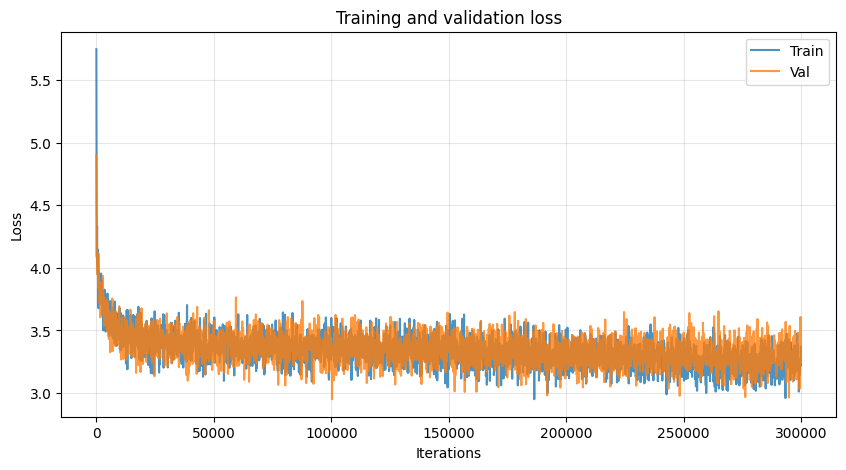

In [11]:
# Plot training and validation loss (each point = track_interval iters)
if len(lossi) > 0:
    iterations = torch.arange(len(lossi)) * track_interval
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, lossi, label="Train", alpha=0.8)
    plt.plot(iterations, val_lossi, label="Val", alpha=0.8)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No loss history (training not run or no track_interval points).")

In [12]:
# Evaluation: train and val loss
@torch.no_grad()
def split_loss(split: str) -> float:
    model.eval()
    splits = {
        "train": (Xtr, Ytr, Ctr),
        "val": (Xdev, Ydev, Cdev),
        "test": (Xte, Yte, Cte),
    }
    X, Y, C = splits[split]
    n = min(2048, X.shape[0])
    Xb = X[:n].to(device)
    Yb = Y[:n].to(device)
    Cb = C[:n].to(device)
    logits, _ = model(Xb, Cb, targets=Yb)
    loss = F.cross_entropy(logits, Yb)
    return loss.item()

# print(f"Train loss: {split_loss('train'):.4f}")
print(f"Val loss:   {split_loss('val'):.4f}")

Val loss:   3.3093


In [17]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "dwarves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(cat_idx, tokenizer.itos, tokenizer.stoi, generator=gen, replace_end_with=None, temperature = .5)
    print(f"[{cat_name}] {name}")

[dwarves] slavar parl
[dwarves] anni alban
[dwarves] durik
[dwarves] johan piri
[dwarves] tran parswor
[dwarves] asmel
[dwarves] juksar
[dwarves] aundrath shak
[dwarves] guldus
[dwarves] hagg
[dwarves] helman ithal
[dwarves] carl cendrin
[dwarves] lorl
[dwarves] mecan eldani
[dwarves] budi


In [14]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "elves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(cat_idx, tokenizer.itos, tokenizer.stoi, generator=gen, temperature=.5, replace_end_with=" ")
    print(f"[{cat_name}] {name}")

[elves] slavar parl cord
[elves] miran the shaster
[elves] gilje chicha
[elves] spars forass obar
[elves] kamah florn
[elves] abra felder haws
[elves] helman ithal
[elves] carl cendrin lor
[elves] jeffred wander
[elves] gali grey fist
[elves] caroline keys
[elves] pella kerssar
[elves] avi steeffer gudd
[elves] galin flay abd
[elves] parrak zabbal


In [16]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 12)

cat_name = "elves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(cat_idx, tokenizer.itos, tokenizer.stoi, generator=gen, temperature=.1, replace_end_with=" ")
    print(f"[{cat_name}] {name}")

[elves] carlen carm
[elves] dora the winder
[elves] summer obarskyr
[elves] hallor fred ca
[elves] sivi night obarsk
[elves] piera the carl
[elves] silver the whester we
[elves] carmel caster
[elves] spertt fald
[elves] melira the brimbon ii
[elves] britt guard
[elves] melia durim ii
[elves] sivi kivan i
[elves] perith green
[elves] summer obarskyr


In [15]:
# Random category sampling
import random

gen = torch.Generator(device=device).manual_seed(2147483647 + 22)
cat_indices = list(cat_vocab.itos.keys())

for _ in range(30):
    c = random.choice(cat_indices)
    cat_label = cat_vocab.itos[c]
    name = model.generate_name(c, tokenizer.itos, tokenizer.stoi, generator=gen)
    print(f"[{cat_label}] {name}")

[weretigers] verthava ingeer domalssia
[pseudodragons] vestza wildam themmant
[bone devils] sorese clowi
[volodni] sasuwam ilbertu
[vampires] gugar waerwanmer
[titans] matete debrown
[chondathans] corvi dyla
[spirit folk] lum daud sabdri sau mansn iiek
[tritons] liamo daf
[phoenixes] cala th irbava
[barghests] umex grebet
[dire wolves] maxmaf stefvilis f
[deep bats] momit cridel
[nimblewrights] rale shaeh
[yochlols] dwalell cars
[eblis] gishmul felsaor
[tasloi] amman thauva
[hamatulas] nruze wlit
[goblins] dorgin farn
[shalarin] marite gjitlino
[sapphire dragons] venos dickygo tuardthro
[gold dwarves] ipcorat ivesta gioveha
[trumpet archons] zermun baenre ali
[devils] maakal baer yo
[swanmays] hyemal aduzell
[jackalweres] bonna ank
[baelnorn liches] yopath phar
[githyanki] yogg pymria
[gnolls] keli kamal
[deep gnomes] vasim phetar 
